In [1]:
import keras
import tensorflow as tf
print('TensorFlow version:', tf.__version__) 
print('Keras version:', keras.__version__)
import sys
import os
from os.path import join
from keras import backend as K
import numpy as np
import cv2
import itertools
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

Using TensorFlow backend.


TensorFlow version: 1.8.0
Keras version: 2.2.2


In [2]:
from keras.models import model_from_json

DEVICE = "/cpu:0"  # /use cpu:0 for cpu only or /gpu:0

In [3]:
working_dir = os.getcwd()
print("Working directory is:",working_dir)
sys.path.append(working_dir)  # To find local version of the library

Working directory is: C:\Users\is95217\source\turkishplate


In [4]:
win=1
if win:
    ROOT_DIR = os.path.join("C:/Users/is95217/source/turkishplate") #win
    DATA_DIR = "C:/Users/is95217/data/Original_15Kcrop_distributed" #win
else:    
    ROOT_DIR = os.path.join("/home/user/Source/Evrim/Turkishplate") #linux
    DATA_DIR = "/home/user/Source/data/dataEvrim/Original_15Kcrop_distributed"  #linux
sys.path.append(ROOT_DIR + "/Python")

print("Data:", DATA_DIR)
print("Source code:", ROOT_DIR)

Data: C:/Users/is95217/data/Original_15Kcrop_distributed
Source code: C:/Users/is95217/source/turkishplate


In [5]:
sys.path.append(os.path.dirname(os.path.realpath('PPlate')) + "/python")
import PPlate as p

# LOAD MODEL 

In [48]:
# load json and create model
#fmodel='lr0.02_mom0.9'
#fmodel = '/Model/Plate15K'

#loaded_model=p.load_model(ROOT_DIR + '/Model/plate15K')
loaded_model=p.load_model(ROOT_DIR + '/model/model15k_2GRU')
#save load weights değil direk save ve load kullanılacak
#model = load_model(con)

# visualize layers

In [49]:
inp = loaded_model.input  
inputs = [layer.input for layer in loaded_model.layers]
outputs = [layer.output for layer in loaded_model.layers]          # all layer outputs

In [50]:
functors = [K.function([inp, K.learning_phase()], [out]) for out in outputs]

In [65]:
inputss

[<tf.Tensor 'the_input_3:0' shape=(?, 128, 64, 1) dtype=float32>,
 <tf.Tensor 'the_input_3:0' shape=(?, 128, 64, 1) dtype=float32>,
 <tf.Tensor 'conv1_3/Relu:0' shape=(?, 128, 64, 16) dtype=float32>,
 <tf.Tensor 'max1_3/MaxPool:0' shape=(?, 64, 32, 16) dtype=float32>,
 <tf.Tensor 'conv2_3/Relu:0' shape=(?, 64, 32, 16) dtype=float32>,
 <tf.Tensor 'max2_3/MaxPool:0' shape=(?, 32, 16, 16) dtype=float32>,
 <tf.Tensor 'reshape_3/Reshape:0' shape=(?, 32, 256) dtype=float32>,
 <tf.Tensor 'dense1_3/Relu:0' shape=(?, 32, 32) dtype=float32>,
 <tf.Tensor 'dense1_3/Relu:0' shape=(?, 32, 32) dtype=float32>,
 [<tf.Tensor 'gru1_3/transpose_1:0' shape=(?, ?, 512) dtype=float32>,
  <tf.Tensor 'gru1_b_3/transpose_1:0' shape=(?, ?, 512) dtype=float32>],
 <tf.Tensor 'add_1_2/add:0' shape=(?, ?, 512) dtype=float32>,
 <tf.Tensor 'add_1_2/add:0' shape=(?, ?, 512) dtype=float32>,
 [<tf.Tensor 'gru2_3/transpose_1:0' shape=(?, ?, 512) dtype=float32>,
  <tf.Tensor 'gru2_b_3/transpose_1:0' shape=(?, ?, 512) dtype

In [11]:
def predict_single_plate(sess,loaded_model,img):
    img_w,img_h = 128, 64
   
    #img = cv2.imread(img_filepath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (img_w, img_h))
    img = img.astype(np.float32)
    img /= 255


    net_inp = loaded_model.get_layer(name='the_input').input
    net_out = loaded_model.get_layer(name='softmax').output

    if K.image_data_format() == 'channels_first':
        X_data = np.ones([1, 1, img_w, img_h])
    else:
        X_data = np.ones([1, img_w, img_h, 1])
    
    img = img.T
    if K.image_data_format() == 'channels_first':
        img = np.expand_dims(img, 0)
    else:
        img = np.expand_dims(img, -1)
    X_data[0] = img

    net_out_value = sess.run(net_out, feed_dict={net_inp:X_data})
    pred_texts = decode_batch(net_out_value)
    print(pred_texts)
    return net_out_value


In [63]:
net_inp =loaded_model.get_layer(name='the_input').input

In [64]:
net_inp

<tf.Tensor 'the_input_3:0' shape=(?, 128, 64, 1) dtype=float32>

In [69]:
net_inp2 =loaded_model.get_layer(name='conv1 ').input

ValueError: No such layer: conv1 

In [68]:
net_inp2

<tf.Tensor 'the_input_3:0' shape=(?, 128, 64, 1) dtype=float32>

In [13]:
letters_train = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'R', 'S', 'T', 'U', 'V', 'Y', 'Z']
letters = sorted(list(letters_train))


In [14]:
def decode_batch(out):
    ret = []
    for j in range(out.shape[0]):
        out_best = list(np.argmax(out[j, 2:], 1))
        out_best = [k for k, g in itertools.groupby(out_best)]
        outstr = ''
        for c in out_best:
            if c < len(letters):
                outstr += letters[c]
        ret.append(outstr)
    return ret

In [15]:
import tensorflow as tf
sess = tf.Session()
K.set_session(sess)

In [16]:
init = tf.global_variables_initializer()
sess.run(init)

In [90]:
image_path= DATA_DIR + '/train/1#01APC48#02042018#112617.jpg'
import skimage
from skimage import io

In [18]:
image = skimage.io.imread(image_path) 

In [19]:
np.shape(image)

(40, 172, 3)

In [22]:
net_out = predict_single_plate(sess,loaded_model,image)


['01APC48']


In [ ]:
np.shape(net_out)

In [ ]:
"""
# Testing
test = np.random.random(net_inp)[np.newaxis,:]
layer_outs = [func([test, 1.]) for func in functors]
print(layer_outs)
"""
#X_data[i] = image

In [24]:
def plot_activation():
          
    fig = plt.figure(figsize=(20, 20))
    outer = gridspec.GridSpec(2, 1, wspace=10, hspace=0.1) 
    ax1 = plt.Subplot(fig, outer[0])
    fig.add_subplot(ax1)
    ax2 = plt.Subplot(fig, outer[1])
    fig.add_subplot(ax2)    
    ax2.set_title('Activations')
   
    ax1.set_title('Input img')
    ax1.imshow(image, cmap='gray')
    ax1.set_xticks([])
    ax1.set_yticks([])

    ax2.imshow(net_out[0].T, cmap='binary', interpolation='nearest')    
    
    ax2.set_yticks(list(range(len(letters) + 1)))
    ax2.set_yticklabels(letters + ['blank'])
    ax2.grid(False)
    for h in np.arange(-0.5, len(letters) + 1 + 0.5, 1):
        ax2.axhline(h, linestyle='-', color='k', alpha=0.5, linewidth=1)

    #ax.axvline(x, linestyle='--', color='k')
    plt.show()

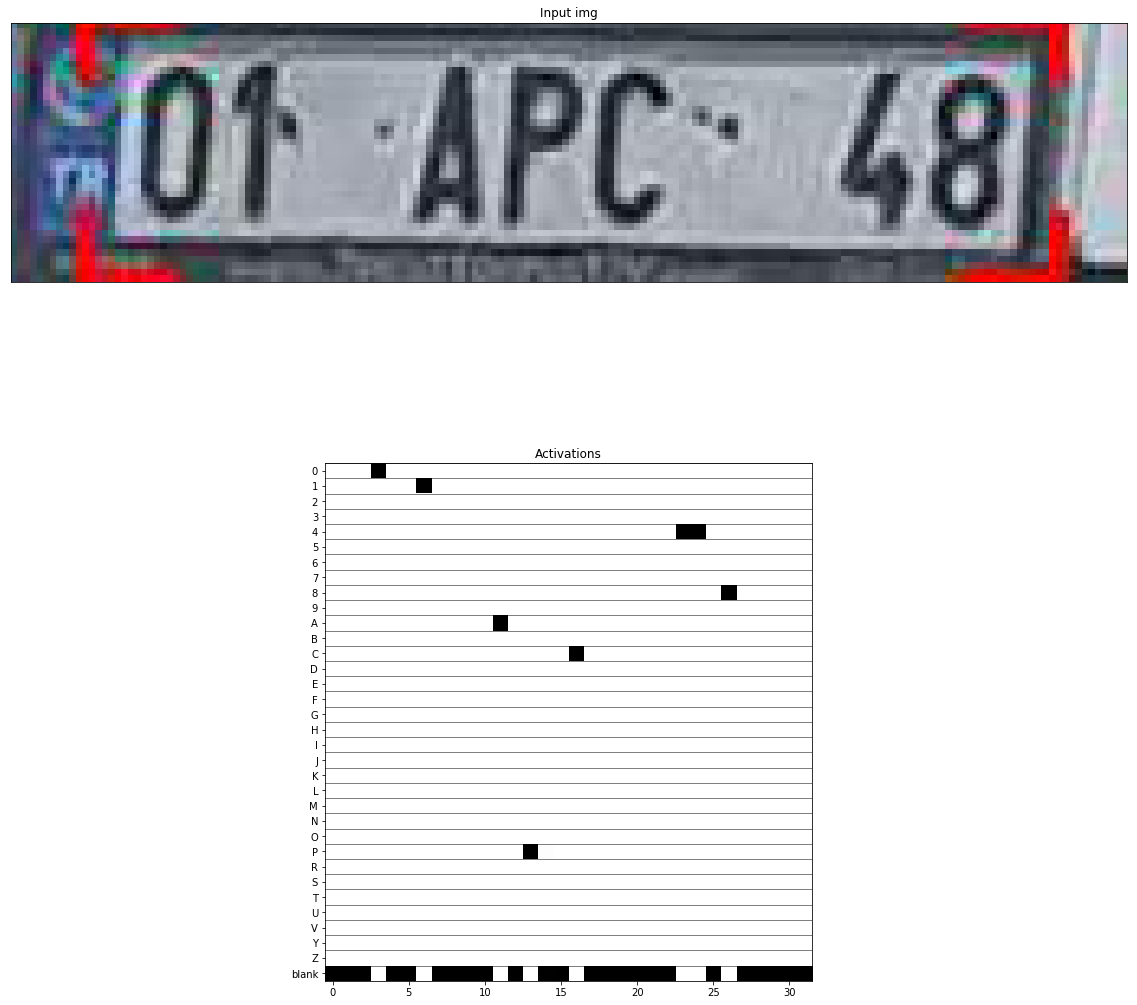

In [25]:
plot_activation()

In [77]:
layer_outputs = [layer.output for layer in loaded_model.layers[:15]] 

In [79]:
layer_outputs

[<tf.Tensor 'the_input_3:0' shape=(?, 128, 64, 1) dtype=float32>,
 <tf.Tensor 'conv1_3/Relu:0' shape=(?, 128, 64, 16) dtype=float32>,
 <tf.Tensor 'max1_3/MaxPool:0' shape=(?, 64, 32, 16) dtype=float32>,
 <tf.Tensor 'conv2_3/Relu:0' shape=(?, 64, 32, 16) dtype=float32>,
 <tf.Tensor 'max2_3/MaxPool:0' shape=(?, 32, 16, 16) dtype=float32>,
 <tf.Tensor 'reshape_3/Reshape:0' shape=(?, 32, 256) dtype=float32>,
 <tf.Tensor 'dense1_3/Relu:0' shape=(?, 32, 32) dtype=float32>,
 <tf.Tensor 'gru1_3/transpose_1:0' shape=(?, ?, 512) dtype=float32>,
 <tf.Tensor 'gru1_b_3/transpose_1:0' shape=(?, ?, 512) dtype=float32>,
 <tf.Tensor 'add_1_2/add:0' shape=(?, ?, 512) dtype=float32>,
 <tf.Tensor 'gru2_3/transpose_1:0' shape=(?, ?, 512) dtype=float32>,
 <tf.Tensor 'gru2_b_3/transpose_1:0' shape=(?, ?, 512) dtype=float32>,
 <tf.Tensor 'concatenate_1_2/concat:0' shape=(?, ?, 1024) dtype=float32>,
 <tf.Tensor 'dense2_3/add:0' shape=(?, 32, 34) dtype=float32>,
 <tf.Tensor 'softmax_3/truediv:0' shape=(?, 32, 3

In [115]:
from keras import models

layer_outputs = [layer.output for layer in loaded_model.layers[:8]]
activation_model = models.Model(inputs=loaded_model.input, outputs=layer_outputs)

In [116]:
loaded_model.input

[<tf.Tensor 'the_input_3:0' shape=(?, 128, 64, 1) dtype=float32>,
 <tf.Tensor 'the_labels_3:0' shape=(?, 8) dtype=float32>,
 <tf.Tensor 'input_length_3:0' shape=(?, 1) dtype=int64>,
 <tf.Tensor 'label_length_3:0' shape=(?, 1) dtype=int64>]

In [117]:
loaded_model.outputs

[<tf.Tensor 'ctc_3/ExpandDims:0' shape=(?, 1) dtype=float32>]

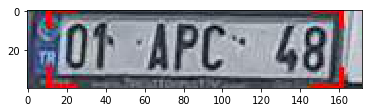

In [81]:
plt.imshow(image)
plt.show()

In [103]:
activation_model

In [87]:
image.shape

(40, 172, 3)

In [93]:
from keras.preprocessing import image
img = image.load_img(image_path, target_size=(64, 128))

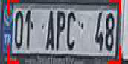

In [94]:
img

In [95]:
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.

In [104]:
img_tensor.shape

(1, 64, 128, 3)

In [99]:
img_tensor[0].shape

(64, 128, 3)

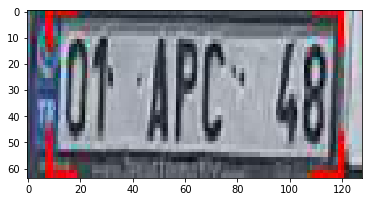

In [100]:
plt.imshow(img_tensor[0])
plt.show()

In [118]:
input_shape= img_tensor.shape
activations = activation_model.predict(img_tensor,'01APC48',8,8)  # CHOLLETIN KODUNU İNCELE

ValueError: Error when checking model input: the list of Numpy arrays that you are passing to your model is not the size the model expected. Expected to see 4 array(s), but instead got the following list of 1 arrays: [array([[[[0.34901962, 0.49411765, 0.59607846],
         [0.23137255, 0.36078432, 0.23921569],
         [0.18039216, 0.4       , 0.29411766],
         ...,
         [0.8039216 , 0.8509804 , 0.9137255 ...